# A Primer into Timeseries analysis

References:
- Initial tutorial from https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- Dataset from https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [3]:
%matplotlib inline
# loading an example dataset

from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas import Series
from matplotlib import pyplot

ts = Series.from_csv('data/daily-minimum-temperatures-in-me.csv', header=0)

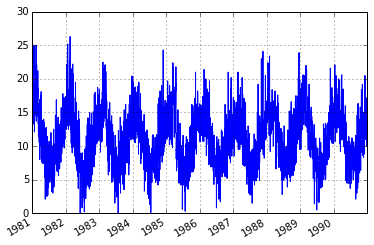

In [2]:
ts.plot()

## Autocorrelation plots
Simply stated, autocorrelation is the correlation of a timeseries with a version of itself which is shifted over time (https://en.wikipedia.org/wiki/Autocorrelation). As such it represents the similarity between samples that are separated by a time lag. This mathematical tool is useful to identify repeating or even periodical patterns.

Statistically speaking, the autocorrelation is the Pearson correlation between values $X_t$ generated by a random process $X$ at each time $t$ and having mean $μ_t$ and variance $σ^2_t$ at time $t$, that means:

${\displaystyle R(s,t)={\frac {\operatorname {E} [(X_{t}-\mu _{t})(X_{s}-\mu _{s})]}{\sigma _{t}\sigma _{s}}}} $

Autocorrelation plots (also called Correlograms) are used to show whether a timeseries containes correlated data points, being them positely or negatively correlated.
The correlation is calculated between the timeserie and itself shifted of different time delays called lag (i.e., adjacent points have lag = 1) and the plot showing the autocorrelation value (in the range -1 to 1) over the time lags.
Consequently, random timeseries have an autocorrelation around the 0 for all time delays, while non-random time series have the autocorrelation for one or more of the lag values away from 0.

Statsmodels is a Python module providing a number of functions to carry out statistical tests and explorative data analysis, as well as fit/extract multiple models and estimators.

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


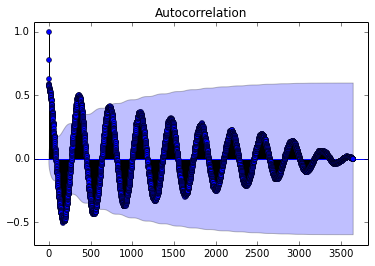

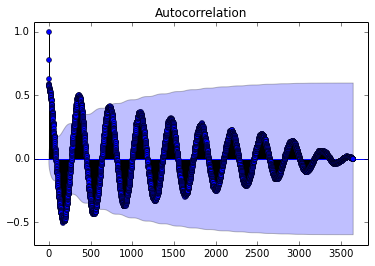

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts)
#plot_acf(ts, lags=50)

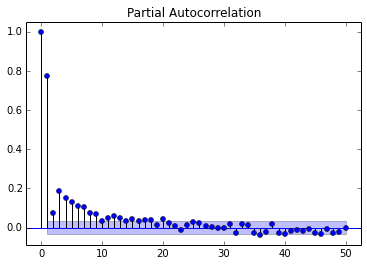

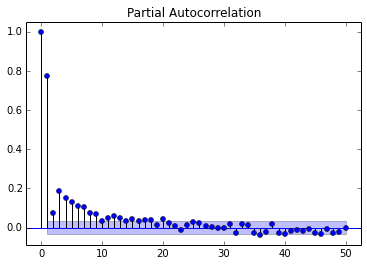

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts, lags=50)

A similar result can be reached with Pandas computational tools (See http://pandas.pydata.org/pandas-docs/stable/computation.html). The toolbox offers a bunch of functions for summarizing and aggregating timeseries, e.g. covariance.

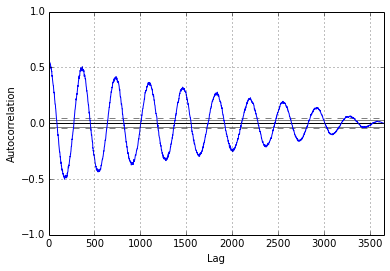

In [5]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(ts)

## Trends in Timeseries
A trend is a non-periodic increase/decrease in the value of a time serie. As such, the trend can be due to deterministic or stochastic latent phenomena, and can affect either a local or the entire (global) time serie. Clearly a time series with a trend is non-stationary and should be preprocessed as extracting a model over a de-trended time series might work better. The trend can finally be re-added on the predicted output if necessary.

Detrending can be implemented in multiple ways: i) by subtracting the previous sample so as to compute a time serie of delta values $(s'(t) = s(t) - s(t-1))$, ii) by fitting a model over the original time serie so that the expected value at time t can be subtracted from the encountered one $(s'(t) = s(t) - p(t))$.

See https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial and  https://machinelearningmastery.com/time-series-trends-in-python/ for a complete example.

## Forecasting using ARIMA
- Tutorial source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html

ARIMA stands for AutoRegressive Integrated Moving Average and consists of:
- Autoregression - the model is based on the time dependence between a sample and a number of lagged samples
- Integration - the time serie is made stationary by removing trends, specifically by subtracting consecutive values
- Moving Average - a rolling window is applied repeatedly on a portion of the time serie and the average is computed to reduce the error and residual

Typically the ARIMA implementation can be configured for each of these aspects: i) the size or order of the lagged samples (AR), ii) the number of times the raw samples are being differenced (I) and iii) the size of the window used to perform the moving average (MA). Clearly, setting any of these parameters to 0 means not using that functionality of ARIMA but rather configuring it for AR, I or MA alone.

In the code below, we fit an arima model over the time serie and perform one-step out-of-sample forecast, which returns i) the forecasted valye, ii) the standard deviation, iii) the confidence interval.

len(train) 70
len(test) 31
Test 1 MSE: 9.819
Test 2 MSE: 23.777

/home/pilillo/.local/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Test 3 MSE: 10.165


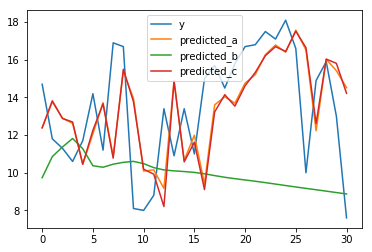

In [161]:
from sklearn.metrics import mean_squared_error

X = ts.values[:101]
# dividing in train and test
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
print "len(train)", len(train)
print "len(test)", len(test)

history = list(train)
predictions_a = list()

# https://machinelearningmastery.com/make-sample-forecasts-arima-python/
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    # One-Step Out-of-Sample Forecast
    output = model_fit.forecast()
    predictions_a.append(output[0])
    history.append(test[t])
    # this makes the history grow with the test data
    # this can have serious scalability issues
    #print('predicted=%f, expected=%f' % (output[0], test[t]))

error = mean_squared_error(test, predictions_a)
print('Test 1 MSE: %.3f' % error)
    
# ------------
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit(disp=0)
predictions_b = model_fit.forecast(steps=len(test))[0]
error = mean_squared_error(test, predictions_b)
print('Test 2 MSE: %.3f' % error)
# ------------

# a more realistic rolling window
predictions_c = list()
history = list(train)
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    # One-Step Out-of-Sample Forecast
    output = model_fit.forecast()
    predictions_c.append(output[0])
    # remove first sample and append the last one
    history = history[1:]+[test[t]]
    #print('predicted=%f, expected=%f' % (output[0], test[t]))

error = mean_squared_error(test, predictions_c)
print('Test 3 MSE: %.3f' % error)
# ------------
pyplot.plot(test, label="y")
pyplot.plot(predictions_a, label="predicted_a")
pyplot.plot(predictions_b, label="predicted_b")
pyplot.plot(predictions_c, label="predicted_c")

pyplot.legend()
pyplot.show()

## TSFresh: Automatic Feature Extraction
TSFRESH is an open Python framework able to automatically extract hundreds of features from time series, such as the number of peaks, the average or maximal value or more complex statistical features. This can clearly save lots of time that would normally be spent for feature engineering.

In [40]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features

# convert pandas series to a dataframe having explicitly the column "time" and the timeseries id "ts"
#c = ts.to_frame().reset_index()
#c.columns = ["time", "value"]
c = ts.to_frame()
c.columns = ["value"]
c['id'] = 1
print c.head()

            value  id
Date                 
1981-01-01   20.7   1
1981-01-02   17.9   1
1981-01-03   18.8   1
1981-01-04   14.6   1
1981-01-05   15.8   1


In [41]:
# https://github.com/blue-yonder/tsfresh/blob/master/notebooks/timeseries_forecasting_basic_example.ipynb
# https://github.com/blue-yonder/tsfresh/blob/master/notebooks/timeseries_forecasting_google_stock.ipynb

df_shift, y = make_forecasting_frame(c["value"], kind="price", max_timeshift=10, rolling_direction=1)
df_shift.head()

/home/pilillo/.local/lib/python2.7/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


,time,value,id,kind
32796,1981-01-01,20.7,1981-01-02,price
29148,1981-01-01,20.7,1981-01-03,price
32797,1981-01-02,17.9,1981-01-03,price
25501,1981-01-01,20.7,1981-01-04,price
29149,1981-01-02,17.9,1981-01-04,price


In [42]:
X = extract_features(df_shift, 
                     column_id="id",
                     column_sort="time",
                     column_value="value",
                     impute_function=impute, 
                     show_warnings=False)

X.head()

Feature Extraction: 10it [03:54, 23.45s/it]                      
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-inf,value__value_count__value_0,value__value_count__value_1,value__value_count__value_inf,value__value_count__value_nan,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1981-01-02,428.49,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1981-01-03,748.90,2.8,-1.000000,-1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.960000,1.0
1981-01-04,1102.34,3.7,-0.470840,-0.470840,0.007653,0.0,0.0,0.0,0.0,0.0,...,-1343.395000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.362222,1.0
1981-01-05,1315.50,7.9,-0.612194,-0.209915,0.843815,0.0,0.0,0.0,0.0,0.0,...,-1679.847500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.875000,1.0
1981-01-06,1565.14,9.1,-0.507058,-0.503965,0.379463,0.0,0.0,0.0,0.0,0.0,...,-1625.058333,-3362.38,0.0,0.0,0.0,0.0,0.0,0.0,4.674400,1.0


As visible the tsfresh generated multiple windows (each having a different id) and automatically extracted a bunch of features on them.

Let's now try to forecast the next value using the extracted features and an AdaBoost tree ensemble.

In [22]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)
# Add last value as feature
X["feature_last_value"] = y.shift(1)
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

(3649, 794)
(3649, 287)


In [33]:
print X.shape
X.head()

(3648, 288)


variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.85,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.95,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_0,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2,748.90,2.8,-1.000000,-1.000000,0.000000,13.7,0.0,0.0,11.00,1.0,...,1.0,1.0,1.0,0.000000,0.000,0.0,0.0,1.960000,1.0,17.9
3,1102.34,3.7,-0.470840,-0.470840,0.007653,13.7,0.0,0.0,11.00,1.0,...,1.0,1.0,1.0,-1343.395000,0.000,0.0,0.0,1.362222,1.0,18.8
4,1315.50,7.9,-0.612194,-0.209915,0.843815,13.7,0.0,0.0,11.00,1.0,...,1.0,1.0,1.0,-1679.847500,0.000,0.0,0.0,4.875000,1.0,14.6
5,1565.14,9.1,-0.507058,-0.503965,0.379463,13.7,0.0,0.0,11.00,1.0,...,1.0,1.0,1.0,-1625.058333,-3362.380,0.0,0.0,4.674400,1.0,15.8
6,1814.78,9.1,-0.452921,-0.689443,0.371167,20.7,-1.0,-4.9,17.56,-1.0,...,1.0,1.0,1.0,-1074.697750,-2197.811,0.0,0.0,4.325556,1.0,15.8





  0%|          | 0/999 [00:00<?, ?it/s]

(1000, 794) (3649, 794)
(1000,) (3649,)
variable    value__abs_energy  value__absolute_sum_of_changes  \
id                                                              
1981-01-02             428.49                             0.0   
1981-01-03             748.90                             2.8   

variable    value__agg_autocorrelation__f_agg_"mean"  \
id                                                     
1981-01-02                                       0.0   
1981-01-03                                      -1.0   

variable    value__agg_autocorrelation__f_agg_"median"  \
id                                                       
1981-01-02                                         0.0   
1981-01-03                                        -1.0   

variable    value__agg_autocorrelation__f_agg_"var"  \
id                                                    
1981-01-02                                      0.0   
1981-01-03                                      0.0   

variable    value__a




  1%|          | 7/999 [00:00<00:40, 24.62it/s]


  1%|          | 8/999 [00:00<00:59, 16.70it/s]


  1%|          | 9/999 [00:00<01:14, 13.37it/s]


  1%|          | 10/999 [00:00<01:26, 11.44it/s]


  1%|          | 11/999 [00:01<01:36, 10.19it/s]


  1%|          | 12/999 [00:01<01:45,  9.32it/s]


  1%|▏         | 13/999 [00:01<01:53,  8.67it/s]


  1%|▏         | 14/999 [00:01<02:00,  8.17it/s]


  2%|▏         | 15/999 [00:01<02:06,  7.79it/s]


  2%|▏         | 16/999 [00:02<02:11,  7.46it/s]


  2%|▏         | 17/999 [00:02<02:16,  7.19it/s]


  2%|▏         | 18/999 [00:02<02:21,  6.95it/s]


  2%|▏         | 19/999 [00:02<02:25,  6.74it/s]


  2%|▏         | 20/999 [00:03<02:29,  6.57it/s]


  2%|▏         | 21/999 [00:03<02:32,  6.42it/s]


  2%|▏         | 22/999 [00:03<02:35,  6.28it/s]


  2%|▏         | 23/999 [00:03<02:38,  6.15it/s]


  2%|▏         | 24/999 [00:03<02:41,  6.04it/s]


  3%|▎         | 25/999 [00:04<02:44,  5.90it/s]


  3%|▎         | 26/999 [00:04<

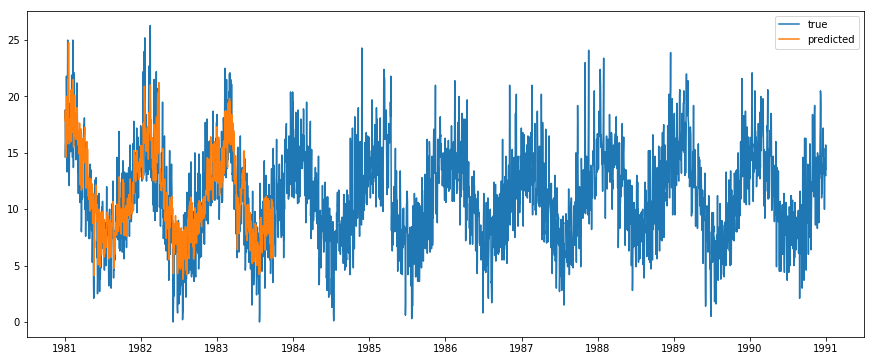

In [92]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators=10)

# to speed this thingie up just run it on a subset (1000 samples)
X_subset = X[:1000]
y_subset = y[:1000]

print X_subset.shape, X.shape
print y_subset.shape, y.shape

y_pred = [0] * len(y_subset)
y_pred[0] = y_subset.iloc[0]

for i in tqdm(range(1, len(y_subset))):
    ada.fit(X_subset.iloc[:i], y_subset[:i])
    y_pred[i] = ada.predict([X_subset.iloc[i, :]])
    
y_pred = pd.Series(data=y_pred, index=y_subset.index)

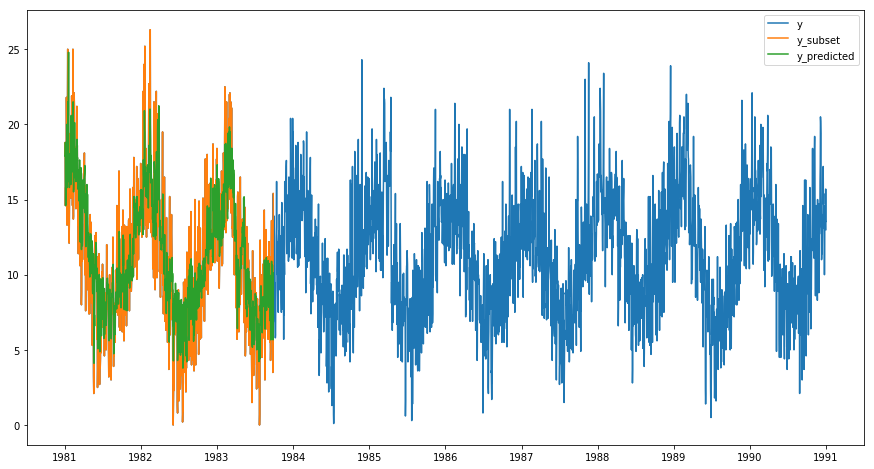

In [109]:
pyplot.figure(figsize=(15, 8))
pyplot.plot(y, label="y")
pyplot.plot(y_subset, label="y_subset")
pyplot.plot(y_pred, label="y_predicted")
pyplot.legend()

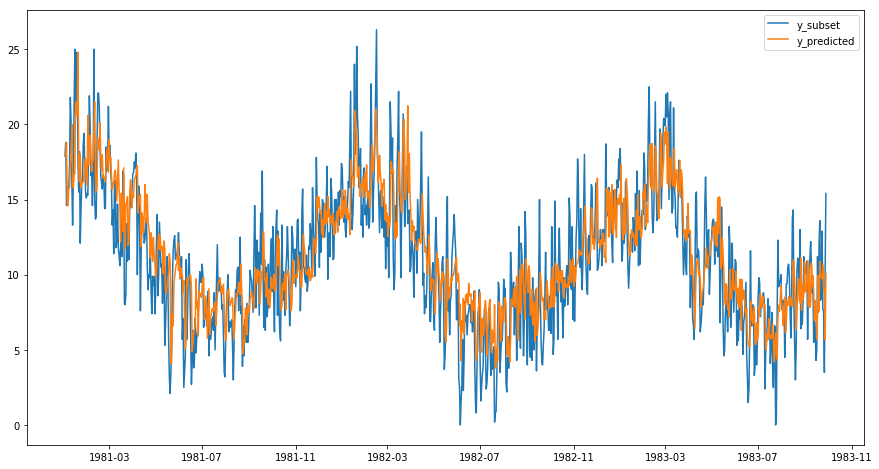

In [97]:
pyplot.figure(figsize=(15, 8))
pyplot.plot(y_subset, label="y_subset")
pyplot.plot(y_pred, label="y_predicted")
pyplot.legend()

# Forecasting using LSTMs

Simple artificial neural network architectures, such as feed-forward networks can be also applied to sequence prediction problems. The methodology is similar to what already seen for other methods, i.e., the input sequence is divided into smaller subsequences which are used to train the network, while the prediction takes place with the already seen rolling window. This has clear limitations given the absence of state (and therefore context) in the network as well as the fixed size of the input window size which does not allow for the learning of short and long term pattern in the data.

- https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
- https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/

Recurrent Neural Networks (RNNs) are especially designed for sequence prediction problems. The main idea is to add feedback loops across the network to allow the addition of a state and consequently improve the expressive power of the network. The Long Short-Term Memory is a special type of RNN which explicitly models the memory in a LSTM unit, along with a input, output and forget gate, respectively used to update the memory component, compute the output value and reset the memory component, and whose behavior can be learned from the data.

The forecasting method being used is once again the rolling window, which we fix as in the original example to 50 samples.
The input for the LSTM is a 3-dimensional tensor (lenght of the input sequence, batch_size, size of input feature vector), i.e. the number of samples in the input sequence, the number of training samples used before an actual update to the network takes place, and for our univariate case the sample value as the only feature. The selection of those values is thoroughly explained at https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/ while https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ shows how to extend the solution to a multivariate time serie.


Let's first of all define a function to produce the training data from the raw time serie.

In [172]:
from pandas import concat

def prepare_train_features(input_series,
                           window_size=5,
                           step_size=1,
                           num_predicted_samples=1,
                           drop_na=True,
                           reset_idx=True):
    col_names = []
    col_vals = []
    df_data = None
    df_forecast = None
    
    for i in range(window_size+num_predicted_samples):
        if df_data is None:
            df_data = input_series.to_frame()
        if i>0:
            df_data = df_data.shift(-step_size)
        col_vals.append( df_data )
        col_names.append( ("f_"+str(i)) if i < window_size else ("y_"+str(i-window_size))  )

    df_data = concat(col_vals, axis=1)
    df_data.columns = col_names
    if drop_na:
        df_data = df_data.dropna(axis=0, how="any")
    df_data.index = range(len(df_data.index))
    return df_data

The input time serie starts with the following samples:

In [173]:
ts.head()

1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
dtype: float64

To predict the output we can train the network in a window of training data and a consecutive ouput sample, and then iterate the process to shift the window of one sample and predict the following sample.
For the test, we could use the same approach, though in reality we won't have any ground truth information.
Consequently, the ideal approach is to feed back the predicted value back to the network in the next window. This approach allows in reality to use the initial window solely as bootup data, with the network being able to forecast multiple future samples by simply using its own forecasts.
This approach clearly reduces the confidence of the produced forecast, with the worst case in which the input window will only consist of predicted values.

In [175]:
window_size=50
prepare_train_features(ts[-window_size-1:], window_size=window_size, drop_na=False).head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,y_0
0,8.6,12.6,13.8,14.6,13.2,12.3,8.8,10.7,9.9,8.3,...,13.2,13.9,10.0,12.9,14.6,14.0,13.6,13.5,15.7,13
1,12.6,13.8,14.6,13.2,12.3,8.8,10.7,9.9,8.3,15.0,...,13.9,10.0,12.9,14.6,14.0,13.6,13.5,15.7,13.0,NaN
2,13.8,14.6,13.2,12.3,8.8,10.7,9.9,8.3,15.0,12.2,...,10.0,12.9,14.6,14.0,13.6,13.5,15.7,13.0,NaN,NaN
3,14.6,13.2,12.3,8.8,10.7,9.9,8.3,15.0,12.2,10.5,...,12.9,14.6,14.0,13.6,13.5,15.7,13.0,NaN,NaN,NaN
4,13.2,12.3,8.8,10.7,9.9,8.3,15.0,12.2,10.5,11.1,...,14.6,14.0,13.6,13.5,15.7,13.0,NaN,NaN,NaN,NaN


This shows the presence of NaN from the shifted sample data, which can be removed with the drop_na parameter.

In [176]:
prepare_train_features(ts[-window_size-1:], window_size=window_size, drop_na=True).head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,y_0
0,8.6,12.6,13.8,14.6,13.2,12.3,8.8,10.7,9.9,8.3,...,13.2,13.9,10,12.9,14.6,14,13.6,13.5,15.7,13


In [228]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout

model = Sequential()
model.add(LSTM(input_shape=(1, window_size),
              output_dim=window_size,
              return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="relu"))

#model.compile(loss="mse", optimizer="rmsprop")
model.compile(loss="mse", optimizer="adam")
model.summary()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(1, 50))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               314368    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 334,825
Trainable params: 334,825
Non-trainable params: 0
_________________________________________________________________


Although not a good idea for comparison, we will use the train dataset also for test purposes, i.e. without separating the data sets (e.g., by a 80/20 split).
We then convert the dataframe to a lstm compatible format (see also https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/, https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/, https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/, https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction)

In [231]:
df = prepare_train_features(ts, window_size=window_size, drop_na=True)
print df.shape

# select the X features
df_x = df.iloc[:,0:window_size]
df_x = np.array(df_x)
print "df_x.shape", df_x.shape

# select the Y features
df_y = df.iloc[:,window_size:]
df_y = np.array(df_y)
print "df_y.shape", df_y.shape

# convert to (samples, timesteps, features)
# i.e. # windows, # samples per window, # features in time serie
train_x = np.reshape(df_x, (df_x.shape[0], 1, df_x.shape[1]))
train_y = np.array(df_y)
#train_y = np.reshape(df_y, (df_y.shape[0], 1, df_y.shape[1]))

print "train_x.shape", train_x.shape
print "train_y.shape", train_y.shape

(3600, 51)
df_x.shape (3600, 50)
df_y.shape (3600, 1)
train_x.shape (3600, 1, 50)
train_y.shape (3600, 1)


In [233]:
n_epoch = 1000
n_batch = len(X)
np.random.seed(1234)

for i in range(n_epoch):
    model.fit(train_x, train_y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)

Epoch 1/1
3600/3600 [==============================] - 0s 33us/step - loss: 136.1387
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 134.1431
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 131.9895
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 129.6185
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 126.9604
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 124.0819
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 120.9010
Epoch 1/1
3600/3600 [==============================] - 0s 30us/step - loss: 117.3530
Epoch 1/1
3600/3600 [==============================] - 0s 29us/step - loss: 113.7788
Epoch 1/1
3600/3600 [==============================] - 0s 31us/step - loss: 109.6917
Epoch 1/1
3600/3600 [==============================] - 0s 29us/step - loss: 105.2600
Epoch 1/1
3600/3600 [==============================] - 0s 34us/st

In [248]:
yhat = model.predict(train_x, batch_size=n_batch)
#for i in range(len(train_y)):
#    print('>Expected=%.1f, Predicted=%.1f' % (y[i], yhat[i]))

# calculate root mean squared error
import math
from sklearn.metrics import mean_squared_error

print train_y.shape
print train_y
print yhat.shape

trainScore = math.sqrt(mean_squared_error(train_y, yhat))
print('Train Score: %.2f RMSE' % (trainScore))

(3600, 1)
[[15.7]
 [16.6]
 [16.5]
 ...
 [13.5]
 [15.7]
 [13. ]]
(3600, 1)
Train Score: 2.26 RMSE


Here is how we would predict all sequences contained in the training data:

In [407]:
print train_x.shape
pp = model.predict(train_x)
print pp.shape
pp

(3600, 1, 50)
(3600, 1)


array([[13.998549],
       [14.859691],
       [15.647421],
       ...,
       [13.613858],
       [14.394776],
       [13.739324]], dtype=float32)

This is how we would predict only the first element:

In [404]:
print "w", train_x[0][0]
w = train_x[0][0]
print "w.shape", w.shape
w = np.reshape(w, (1, 1, w.shape[0]))
print "w.shape", w.shape
p = model.predict(w)
print "p:", p
print "p.shape", p.shape

w [20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5
 25.  20.7 20.6 24.8 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2
 15.5 15.1 15.4 15.3 18.8 21.9 19.9 16.6 16.8 14.6 17.1 25.  15.  13.7
 13.9 18.3 22.  22.1 21.2 18.4 16.6 16.1]
w.shape (50,)
w.shape (1, 1, 50)
p: [[13.998549]]
p.shape (1, 1)


Let's now plot the predictions to see how much they diverge graphically.

In [522]:
def predict_next_sample(md, data_x):
    predicted = md.predict(data_x)
    #print predicted.shape
    predicted = np.reshape(predicted, (predicted.size,))
    #print predicted.shape
    return predicted

def predict_using_forecasts(md, data_x):
    # result returned as (no_results, 1)
    predicted = None
    # use a window of real data as initial window
    input_window = data_x[0]
    input_window = np.reshape(input_window, (input_window.shape[1],))
    #for i in range(2):
    for i in range(data_x.shape[0]):
        #print "input_window.shape", input_window.shape
        input_window = np.reshape(input_window, (1, 1, input_window.shape[0]))
        last_prediction = md.predict(input_window)
        #print "last_prediction", last_prediction
        if predicted is None:
            predicted = last_prediction
        else:
            predicted = np.append(predicted, last_prediction) #, axis=0)
        # prepare window for the next step
        #print "input_window", input_window, input_window.shape
        input_window = np.reshape(input_window, input_window.shape[2])
        #print "input_window", input_window
        # add forecasted value to the window shifted by 1
        input_window = np.append(input_window[1:], # remove the first element from the window
                      last_prediction) # add the last predicted value to the window
        #print "updated input_window", input_window, "with", last_prediction
    return predicted

def plot_predict_next_sample(raw_ts,
                             t_x,
                             predicted,
                             window_size):
    pyplot.figure()
    # plot the initial time serie
    pyplot.plot(raw_ts.index, raw_ts.values, 'b')
    p_ts = Series(predicted[:len(raw_ts)-window_size],
                  index=raw_ts.index[window_size:])
    pyplot.plot(p_ts.index, p_ts.values, 'r')
    pyplot.xticks(rotation=90)

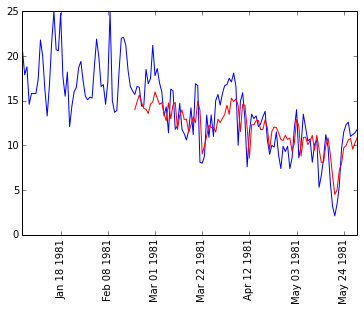

In [523]:
plot_predict_next_sample(ts[:window_size*3],
                         train_x,
                         predict_next_sample(model, train_x),
                         window_size=50)

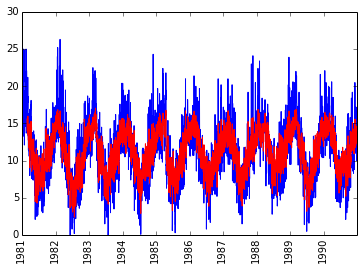

In [524]:
plot_predict_next_sample(ts,
                         train_x,
                         predict_next_sample(model, train_x),
                         window_size=50)

This is just to see what basically the network outputs given the reference time serie we used to train it, though as said pretty useless (since it is like cheating) in reality.
Let's then predict the data using the forecasted samples to see how the confidence of the network decays over consecutive iterations.

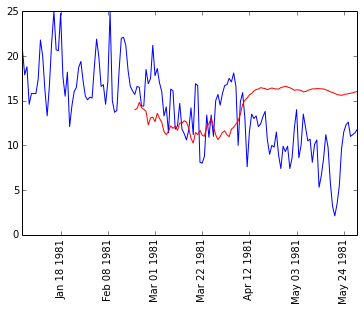

In [525]:
plot_predict_next_sample(ts[:window_size*3],
                         train_x,
                         predict_using_forecasts(model, train_x),
                         window_size=50)

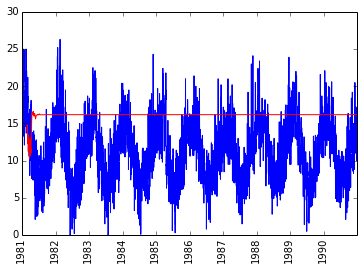

In [526]:
plot_predict_next_sample(ts,
                         train_x,
                         predict_using_forecasts(model, train_x),
                         window_size=50)

In [443]:
"""
tmp_x = np.reshape(df_x, (df_x.shape[0], df_x.shape[1]))
print tmp_x.shape
print tmp_x[0][1:]
"""
tmp_x = train_x[0]

w = np.append(tmp_x[0][1:], # remove the first element from the window
              [1]) # add the last predicted value to the window

print w.shape
w = np.reshape(w, (1, 1, w.shape[0]))
print w.shape
predicted = np.array([[]])
p = model.predict(w)
print "p.shape", p.shape
print "p:", p
#p = np.reshape(p, 1)
#print "p:", p

print "len(predicted)", len(predicted[0])
predicted = np.append(predicted, p, axis=1)
print predicted
predicted = np.append(predicted, p, axis=0)
print predicted
print predicted.shape

(50,)
(1, 1, 50)
p.shape (1, 1)
p: [[7.223291]]
len(predicted) 0
[[7.22329092]]
[[7.22329092]
 [7.22329092]]
(2, 1)
